In [1]:
filename_weather = "Ukraine.csv"
#filename_green = "ukr-ndvi-adm2-full.csv"
filename_green = "uk_green.csv"
#start = 2006
#end = 2021

In [100]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

class WeatherModel():
    def __init__(self, filename, start_year=2003, end_year=2024, model_type='ARIMA'):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'STP'])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[(self.data['DATE'].dt.year >= start_year) & (self.data['DATE'].dt.year <= end_year)]
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.ffill()

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

        self.model_type = model_type

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]]
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, train_stop=None, seasonal_order=None):

        # if train_stop is None:

        if self.residuals is None:
            self.get_residuals()

        arma_models = []

        pbar = tqdm(total=self.residuals.shape[1])

        for i in range(self.residuals.shape[1]):
            pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} {self.model_type} models")
            pbar.update(1)

            if self.model_type == 'ARIMA':
                model = ARIMA(self.residuals[:, i], order=order)
            elif self.model_type == 'SARIMAX':
                if seasonal_order is None:
                    seasonal_order = (1, 0, 1, 365)
                model = SARIMAX(self.residuals[:, i], order=order, seasonal_order=seasonal_order)
            else:
                raise ValueError(f"Invalid model type. Choose 'ARIMA' or 'SARIMAX'. Got {self.model_type}.")
            model_fit = model.fit()
            arma_models.append(model_fit)
            
        self.arma_models = arma_models

        return None
        # else:

        #     if self.residuals is None:
        #         self.get_residuals()

        #     arma_models = []

        #     pbar = tqdm(total=self.residuals[:,train_stop].shape[1])

        #     for i in range(self.residuals.shape[:,train_stop][1]):
        #         pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
        #         pbar.update(1)
        #         model = ARIMA(self.residuals[:, i], order=order)
        #         model_fit = model[:,train_stop].fit()
        #         arma_models.append(model_fit)
                
        #     self.arma_models = arma_models

        # return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    # def fit(self, p,q, train_stop = None):
    #     self.fit_arma(order = (p,0,q), train_stop)
        # return None

    # def Grid(self):
    #     dict_for_GS = dict()
    #     dict_for_GS[p0] = [0,1,2,3,4,5,6,7]
    #     dict_for_GS[q0] = [0,1,2,3,4,5,6,7]
    #     GS = GridSearchCV(wm.fit, dict_for_GS, n_jobs = -1)
    #     GS.f=best_score
    #     wm.fit(1,0,1)
    #     models = wm.arma_models
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



In [102]:
# wm = WeatherModel(filename_weather, model_type='SARIMAX')

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

# dict_for_GS = dict()
# dict_for_GS["p0"] = [0,1,2,3,4,5,6,7]
# dict_for_GS["q0"] = [0,1,2,3,4,5,6,7]
# GS = GridSearchCV(wm, dict_for_GS, n_jobs = -1, scoring = score)
# GS.fit(wm.data)
# #GS.f = best_score
# models = wm.arma_models

#Making values to look over
wm = WeatherModel(filename_weather, model_type='SARIMAX')


wm.fit(order=(1, 0, 1))

/tmp/ipykernel_53595/3378450940.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13559D+00    |proj g|=  4.17021D-02


 This problem is unconstrained.



At iterate    5    f=  3.13437D+00    |proj g|=  5.73505D-03

At iterate   10    f=  3.12948D+00    |proj g|=  2.45012D-02

At iterate   15    f=  3.11661D+00    |proj g|=  7.47314D-03


Fitting 1/8 ARMA models:  12%|█▎        | 1/8 [2:24:29<16:51:26, 8669.54s/it]


KeyboardInterrupt: 

In [4]:
predictions = wm.predict(start=0, future=365*10)

Seasonal Predictions (11315, 8)
Residual shape (8, 11316)
Num stacks 31
Num extras 1


(8, 11316)
(8, 7665)


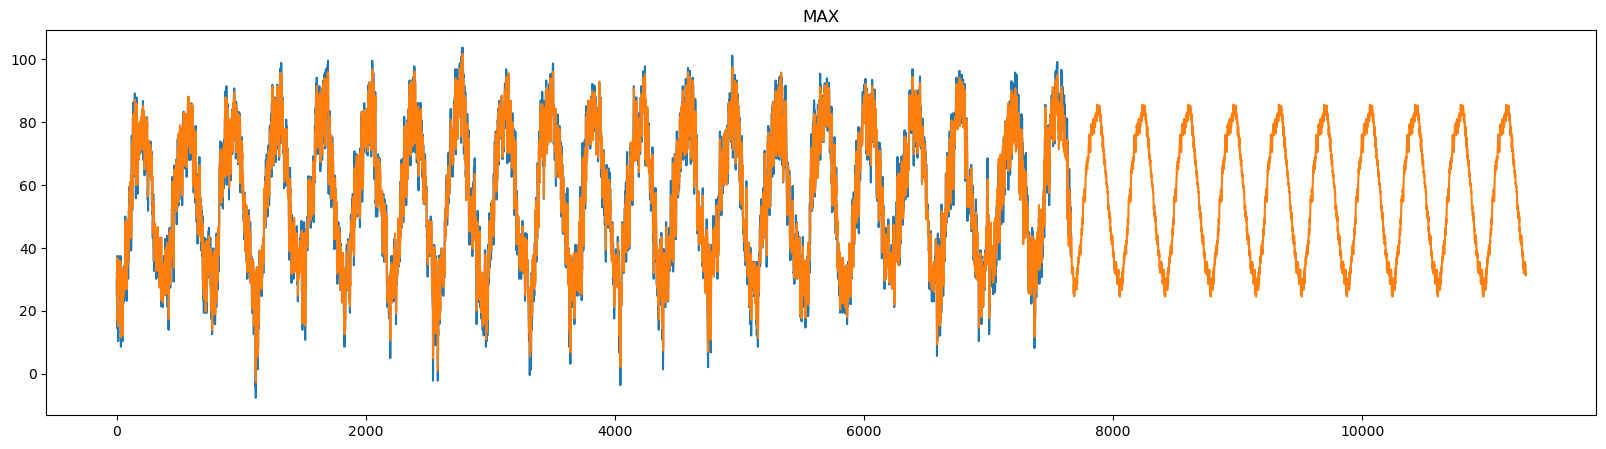

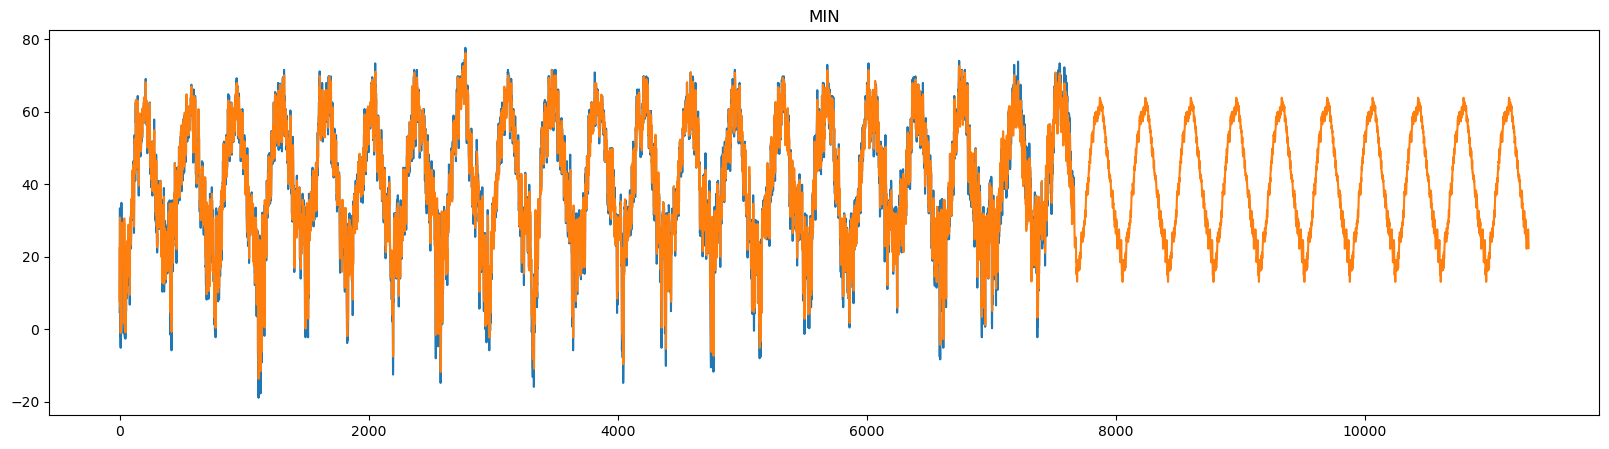

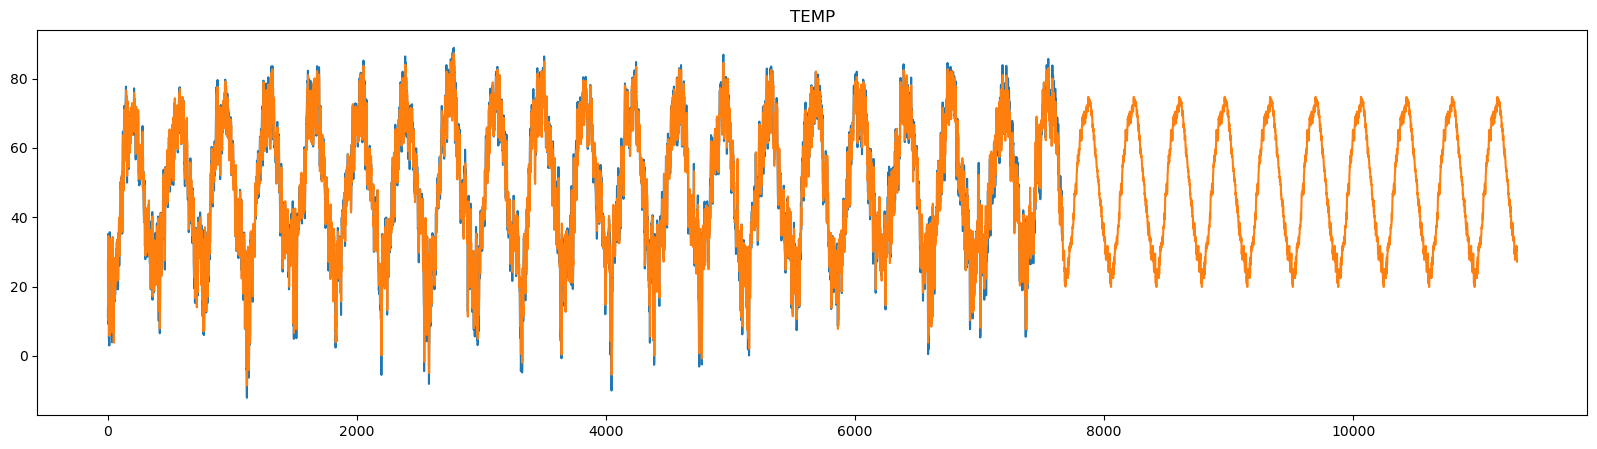

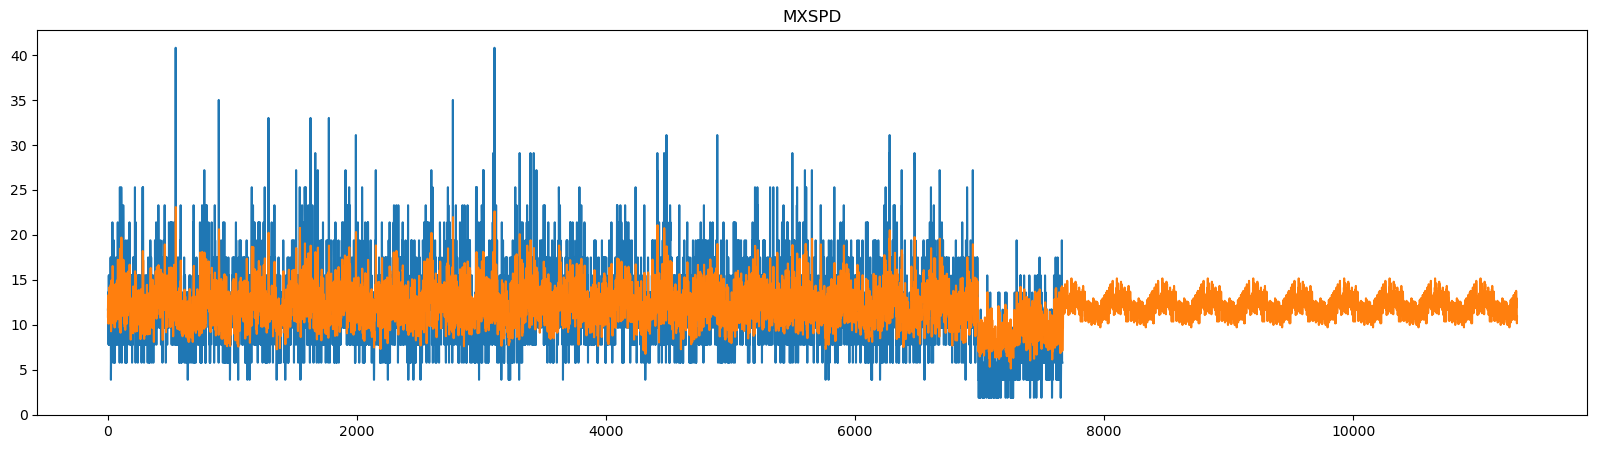

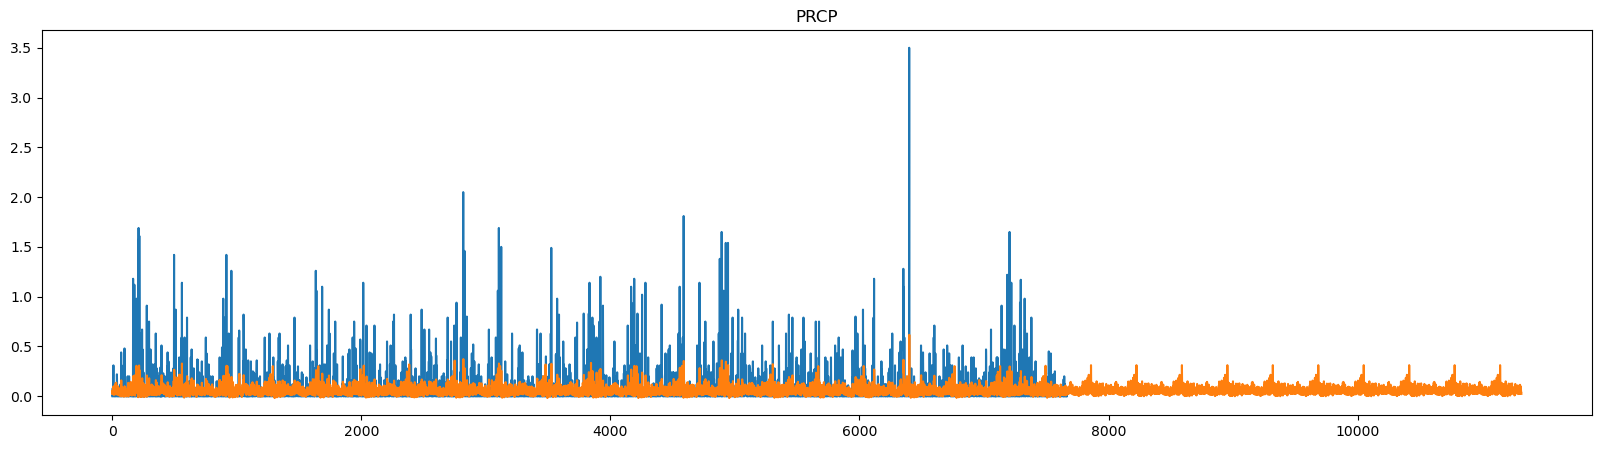

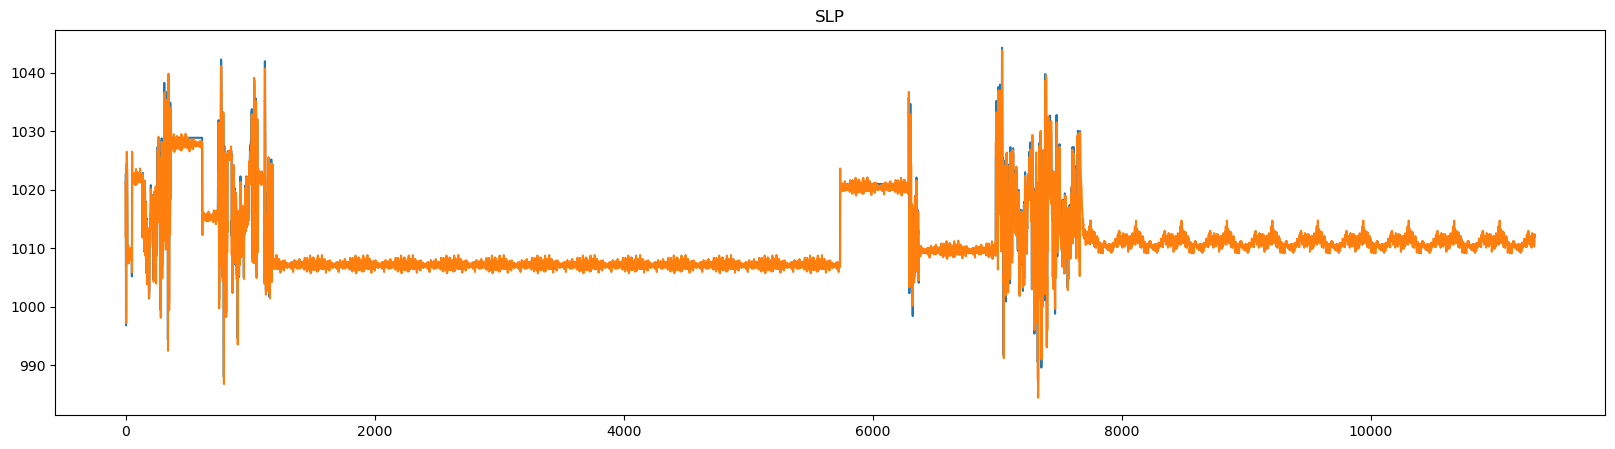

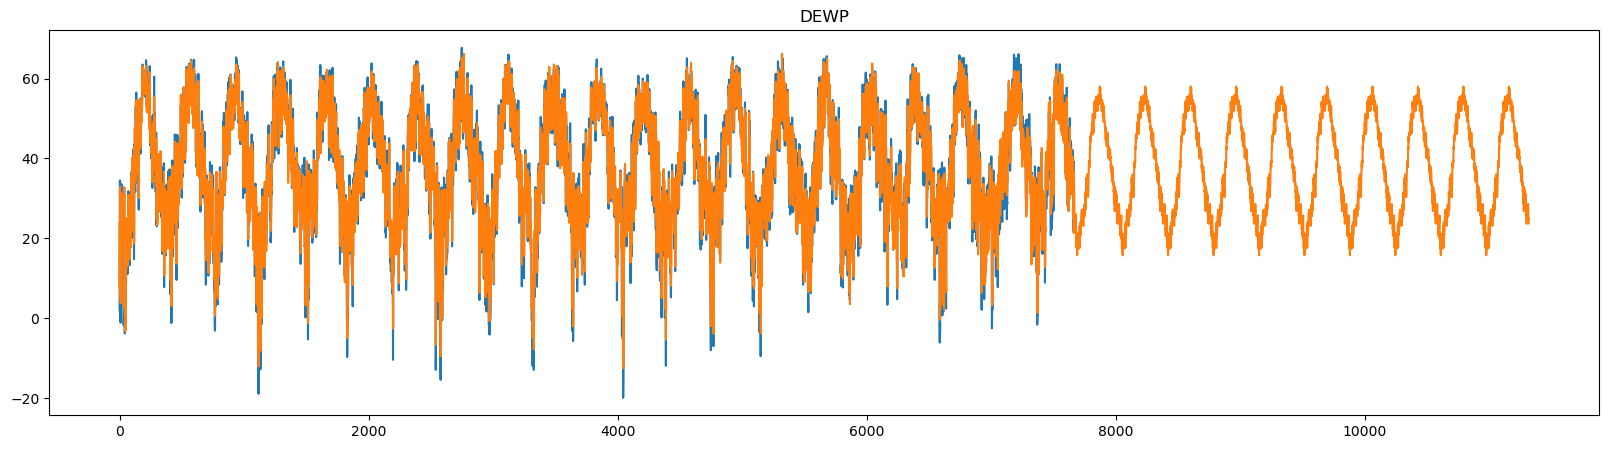

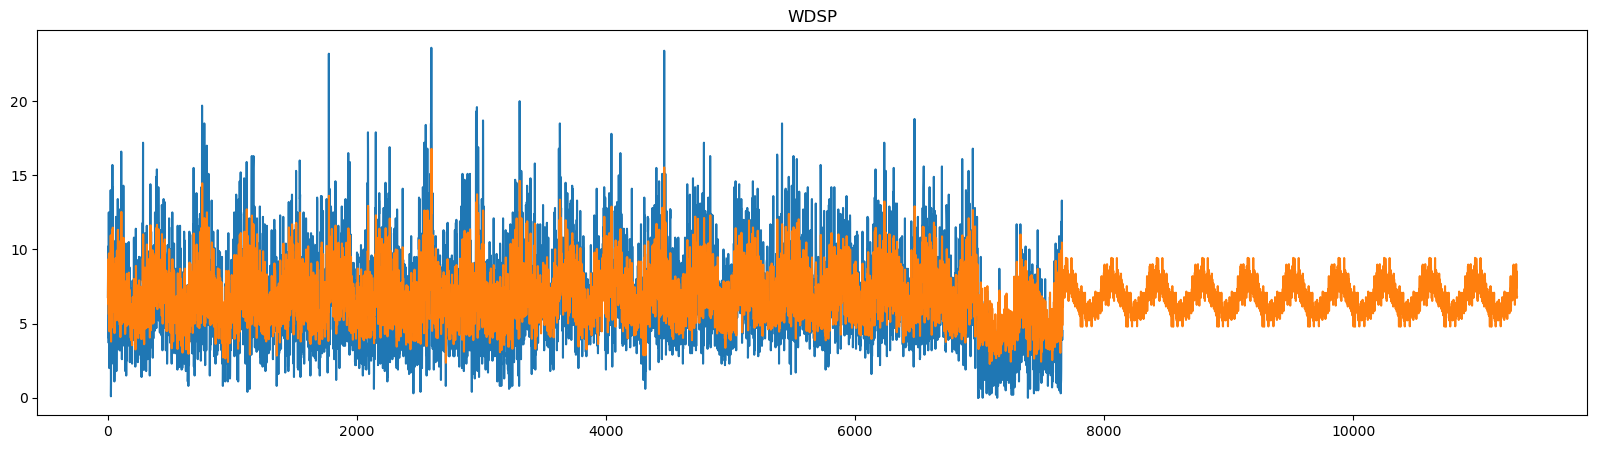

In [5]:
print(predictions.shape)

unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
print(unrolled_data.shape)
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


MAX      0
MIN      0
TEMP     0
MXSPD    0
PRCP     0
SLP      0
DEWP     0
WDSP     0
dtype: int64
(228,)
green (228,)
#date
2003-01-31    0.167667
2003-02-28    0.054767
2003-03-31    0.083767
2003-04-30    0.257833
2003-05-31    0.469167
Freq: ME, Name: residuals, dtype: float64 #date
2021-08-31    0.566000
2021-09-30    0.519700
2021-10-31    0.446967
2021-11-30    0.330033
2021-12-31    0.190767
Freq: ME, Name: residuals, dtype: float64
##################################
                  MAX        MIN       TEMP      MXSPD      PRCP          SLP  \
DATE                                                                            
2003-01-31  28.229032  17.183871  23.109677  11.793548  0.039032  1012.216129   
2003-02-28  22.660714   9.814286  17.232143  12.767857  0.015714  1012.546429   
2003-03-31  34.080645  21.258065  27.977419  12.974194  0.033548  1022.600000   
2003-04-30  51.356667  35.210000  43.443333  14.186667  0.034667  1022.600000   
2003-05-31  75.619355  53.983871

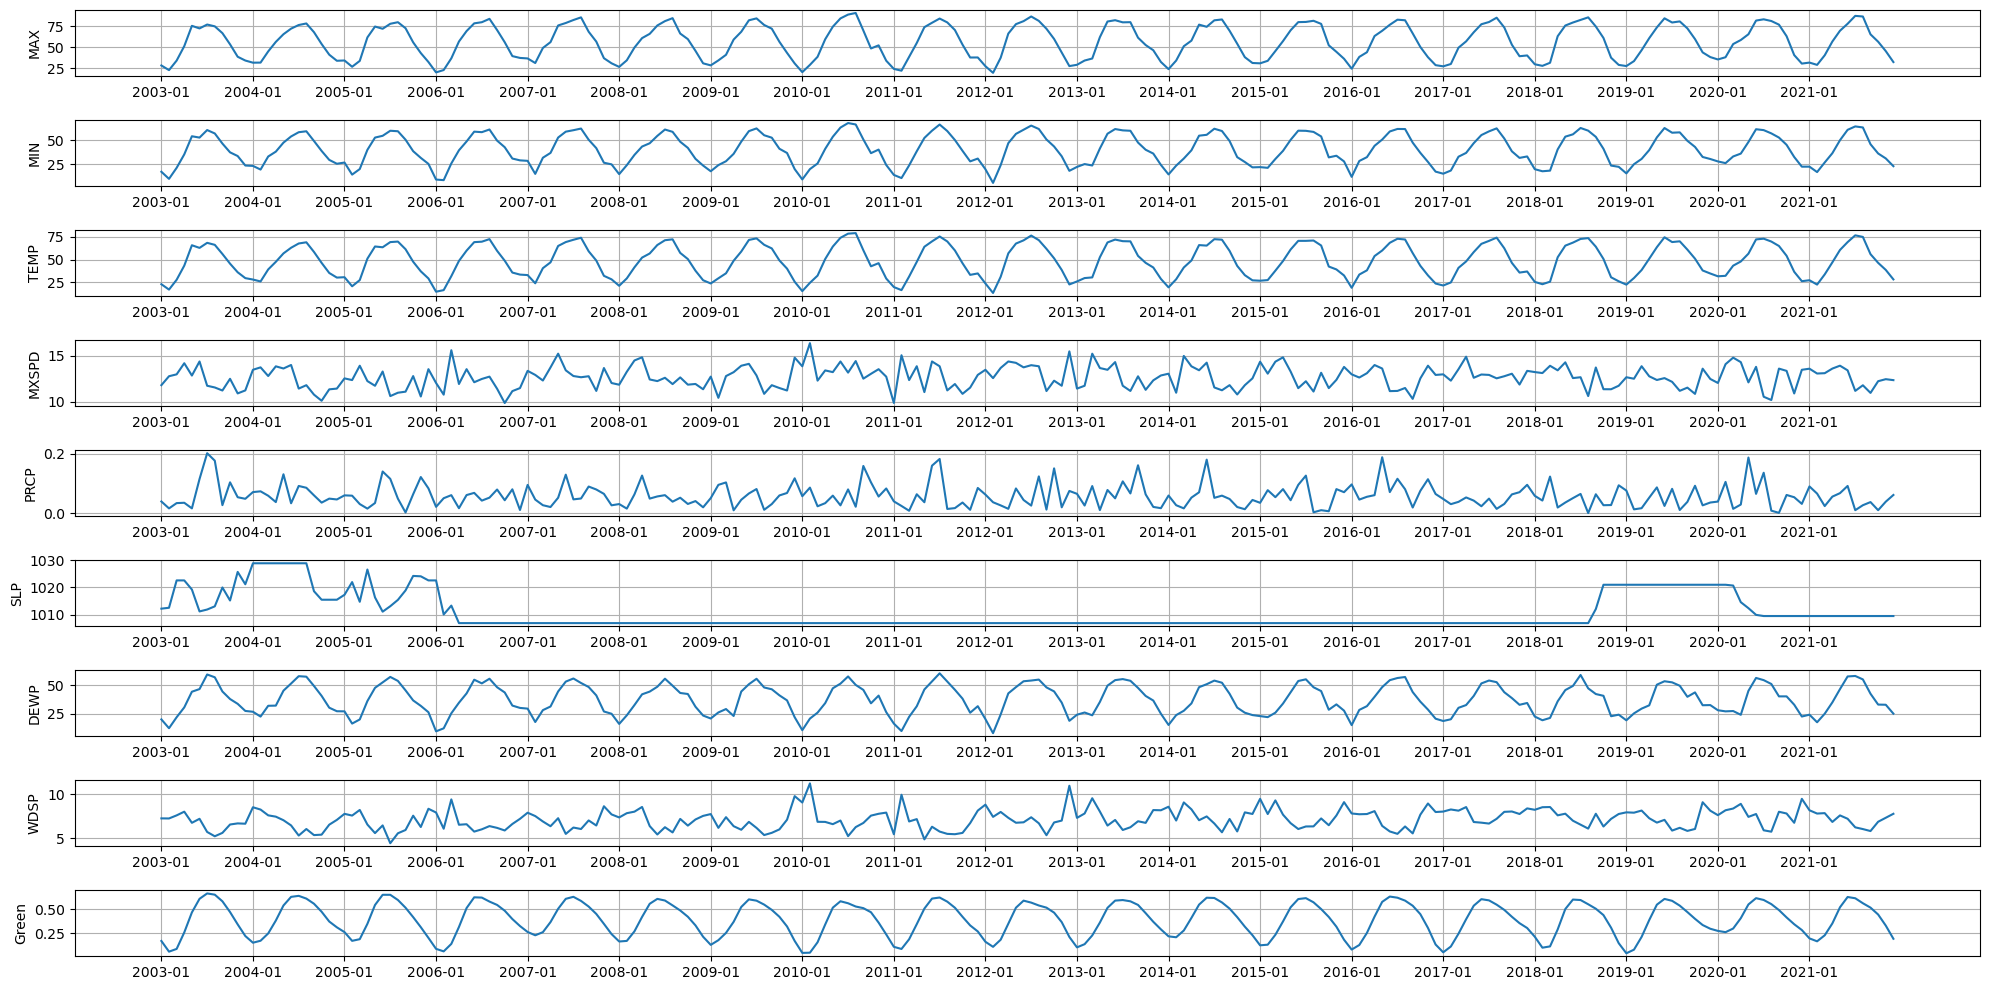

(228,)
(8, 228)


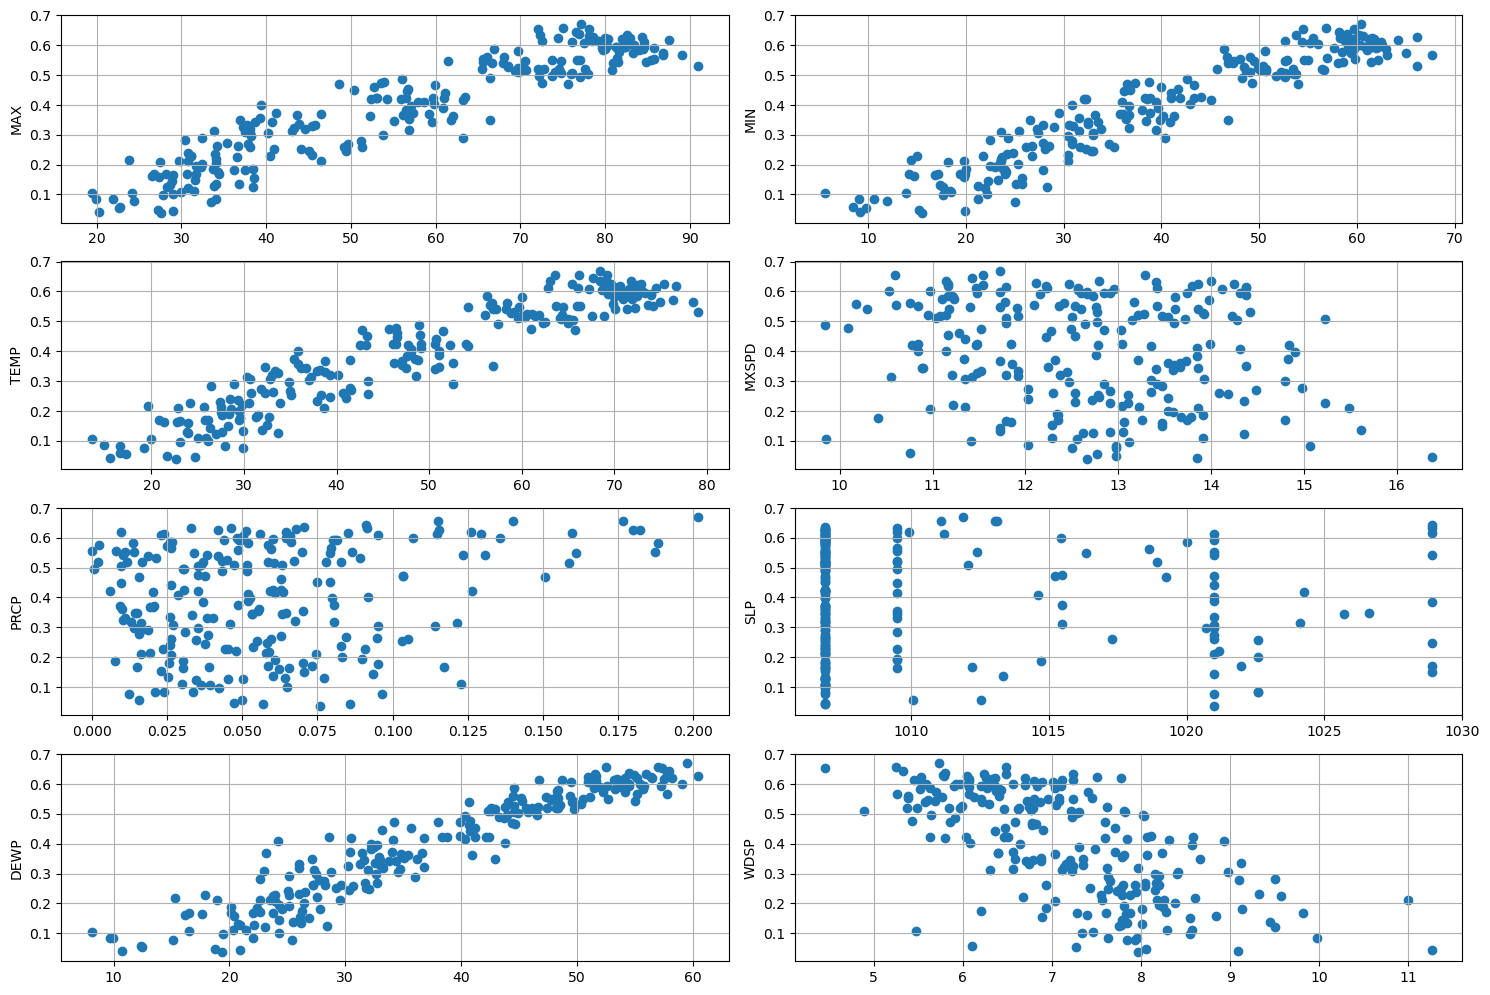

In [6]:
#Plotting the scatter of feature vs food prioce for triend
# unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
# weather = pd.read_csv('ilocos-sur-weather.csv')
# weather = weather[["DATE"] + feature_names]

# wdata = weather[feature_names].to_numpy()
# wdata -= wm.seasonal
# wdata = wdata.reshape(-1, wdata.shape[2]).T

# wdata = pd.DataFrame(wdata, columns=feature_names)
# weather = weather[["DATE"] + feature_names]


# weather = weather.set_index("DATE")
# weather = weather.resample('ME').max()

weather = pd.DataFrame(wm.data[feature_names], columns=feature_names)
print(weather.isna().sum())
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather["DATE"] = wm.data["DATE"]
weather = weather[(weather["DATE"].dt.year >= 2003) & (weather["DATE"].dt.year < 2022)]
weather = weather.set_index("DATE")
weather = weather.resample('ME').mean()

green = pd.read_csv(filename_green)#, skiprows=1)#, ignore_row=1)
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year < 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('ME').mean()
print(green.shape)

print("green", green.shape)

print(green.head(), green.tail())
print("##################################")
print(weather.head(), weather.tail())

y = green.values
weather = weather.to_numpy().T
print(weather.shape)
print(wm.seasonal.shape)

plt.figure(figsize=(20, 10))


for i in range(len(weather)):
    plt.subplot(len(weather)+1, 1, i+1)
    plt.plot(weather[i])
    plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
 
    plt.ylabel(feature_names[i])
    plt.grid()


plt.subplot(len(weather)+1, 1, len(weather)+1)
plt.plot(y)
plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
plt.ylabel("Green")
plt.grid()
plt.tight_layout()

plt.show()

print(y.shape)
print(weather.shape)
plt.figure(figsize=(15, 10))
for i in range(len(weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(weather[i], y)
    plt.ylabel(feature_names[i])
    plt.grid()

plt.tight_layout()
plt.show()




In [53]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

class NonlinearLeastSquaresModel():
    def __init__(self, lmda=0.1):
        self.theta = None
        self.shift = None
        self.scale = None
        self.bias = None
        self.lmda = lmda

    def fit(self, X, y):
        # Can use smoothing here
        basis_funcs = []
        xs = np.arange(X.shape[1])
        
        shift0 = np.zeros(X.shape[0])
        scale0 = np.ones(X.shape[0])
        bias0 = 0
        theta0 = np.concatenate([shift0, scale0, [bias0]])

        def f(theta):
            shift = theta[:X.shape[0]]
            scale = theta[X.shape[0]:-1]
            bias = theta[-1]

            predictions = np.zeros(X.shape[1]) 
            for i in range(X.shape[0]):
                func = CubicSpline(xs, X[i])
                predictions += func(xs-shift[i]) * scale[i]
            predictions += bias

            return np.mean((predictions - y)**2) + self.lmda * np.sum(np.abs(theta))
        
        res = minimize(f, theta0, method='L-BFGS-B', options={'disp': True})
        # res = minimize(f, theta0, method='Nelder-Mead', options={'disp': True, 'maxiter': 1000})
        self.theta = res.x
        self.shift = self.theta[:X.shape[0]]
        self.scale = self.theta[X.shape[0]:-1]
        self.bias = self.theta[-1]
        self.basis_funcs = basis_funcs
        return res

    def predict(self, X):
        print(X.shape)
        predictions = np.zeros(X.shape[1])
        xs = np.arange(X.shape[1])
        for i in range(X.shape[0]):
            func = CubicSpline(xs, X[i])
            predictions += func(xs - self.shift[i]) * self.scale[i] 

        predictions += self.bias
        return predictions


In [79]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

class NonlinearLeastSquaresModelGaussian():
    def __init__(self, lmda=0.1):
        self.theta = None
        self.shift = None
        self.scale = None
        self.bias = None
        self.lmda = lmda

    def fit(self, X, y):
        # Can use smoothing here
        basis_funcs = []
        xs = np.arange(X.shape[1])
        
        shift0 = np.zeros(X.shape[0])
        scale0 = np.ones(X.shape[0])
        var0 = np.ones(X.shape[0])
        bias0 = 0
        theta0 = np.concatenate([shift0, scale0, var0, [bias0]])
        
        X_mean = np.mean(X, axis=1, keepdims=True)
        X_std = np.std(X, axis=1, keepdims=True)
        X = (X - X_mean) / X_std

        def f(theta):
            shift = theta[:X.shape[0]]
            scale = theta[X.shape[0]:2*X.shape[0]]
            var = theta[2*X.shape[0]:-1]
            bias = theta[-1]

            predictions = np.zeros(X.shape[1]) 
            for i in range(X.shape[0]):
                func = CubicSpline(xs, X[i])
                predictions += np.exp(-((func(xs-shift[i])/var[i])**2)) * scale[i]
            predictions += bias

            return np.mean((predictions - y)**2) + self.lmda * np.sum(np.abs(theta))
        
        res = minimize(f, theta0, method='L-BFGS-B', options={'disp': True})
        # res = minimize(f, theta0, method='Nelder-Mead', options={'disp': True, 'maxiter': 1000})
        self.theta = res.x
        self.shift = self.theta[:X.shape[0]]
        self.scale = self.theta[X.shape[0]:2*X.shape[0]]
        self.var = self.theta[2*X.shape[0]:-1]
        self.bias = self.theta[-1]
        self.basis_funcs = basis_funcs
        return res

    def predict(self, X):
        print(X.shape)
        predictions = np.zeros(X.shape[1])
        xs = np.arange(X.shape[1])
        for i in range(X.shape[0]):
            func = CubicSpline(xs, X[i])
            predictions += np.exp(-((func(xs-self.shift[i])/self.var[i])**2)) * self.scale[i]

        predictions += self.bias
        return predictions


In [85]:
gm = NonlinearLeastSquaresModel(lmda=0)
# MAX  MIN TEMP PRCP DEWP WDSP
feature_idxs = [0, 1, 2, 4, 6, 7]
print([feature_names[idx] for idx in feature_idxs])
features = weather[feature_idxs]
train_features = features[:, :150]
test_features = features[:, 150:]
gm.fit(features, y)


['MAX', 'MIN', 'TEMP', 'PRCP', 'DEWP', 'WDSP']
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00894D+04    |proj g|=  2.39528D+04

At iterate    1    f=  1.03449D+04    |proj g|=  1.21621D+04

At iterate    2    f=  8.97284D+00    |proj g|=  1.79282D+01

At iterate    3    f=  7.06076D+00    |proj g|=  1.51674D+01

At iterate    4    f=  2.78326D-01    |proj g|=  2.27744D+00

At iterate    5    f=  1.96382D-01    |proj g|=  8.54717D-01

At iterate    6    f=  1.60847D-01    |proj g|=  1.02302D+00

At iterate    7    f=  1.24484D-01    |proj g|=  1.23667D+00

At iterate    8    f=  2.07164D-02    |proj g|=  1.02309D+00


 This problem is unconstrained.



At iterate    9    f=  9.41466D-03    |proj g|=  1.13010D+00

At iterate   10    f=  4.00124D-03    |proj g|=  6.84909D-02

At iterate   11    f=  3.81283D-03    |proj g|=  1.55586D-02

At iterate   12    f=  3.78655D-03    |proj g|=  9.60348D-03

At iterate   13    f=  3.72128D-03    |proj g|=  4.01514D-01

At iterate   14    f=  3.68261D-03    |proj g|=  5.98932D-01

At iterate   15    f=  3.58820D-03    |proj g|=  7.00648D-02

At iterate   16    f=  3.49749D-03    |proj g|=  2.55366D-01

At iterate   17    f=  3.46144D-03    |proj g|=  1.85622D-01

At iterate   18    f=  3.45491D-03    |proj g|=  3.29488D-02

At iterate   19    f=  3.45458D-03    |proj g|=  4.89235D-03

At iterate   20    f=  3.45443D-03    |proj g|=  1.63281D-02

At iterate   21    f=  3.45433D-03    |proj g|=  1.76931D-02

At iterate   22    f=  3.45365D-03    |proj g|=  1.47136D-02

At iterate   23    f=  3.44761D-03    |proj g|=  9.75739D-02

At iterate   24    f=  3.43619D-03    |proj g|=  2.18759D-01

At iter

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0018485519029469272
        x: [ 9.123e-01  9.152e-01 ... -6.392e-03 -7.564e-02]
      nit: 88
      jac: [-8.030e-05 -1.393e-06 ... -2.429e-05  8.459e-05]
     nfev: 1512
     njev: 108
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     88    108      1     0     0   2.229D-04   1.849D-03
  F =   1.8485519029469272E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


(6, 150)


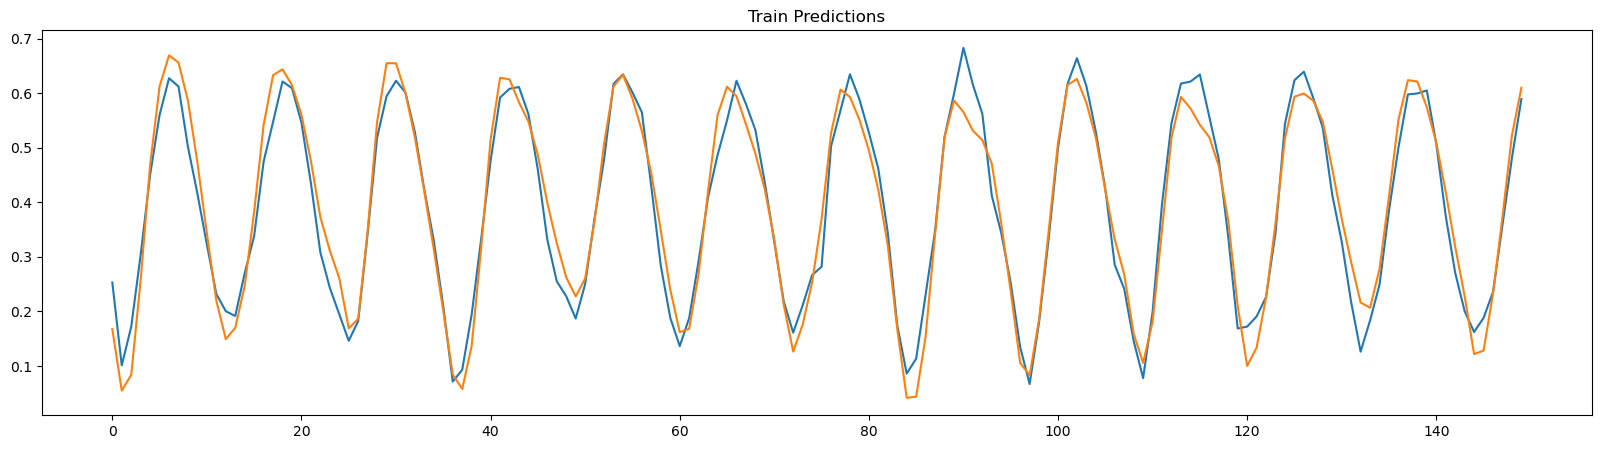

In [86]:
train_pred = gm.predict(train_features)
plt.figure(figsize=(20, 5))
plt.title("Train Predictions")
plt.plot(train_pred)
plt.plot(y[:150])
plt.show()

(6, 78)


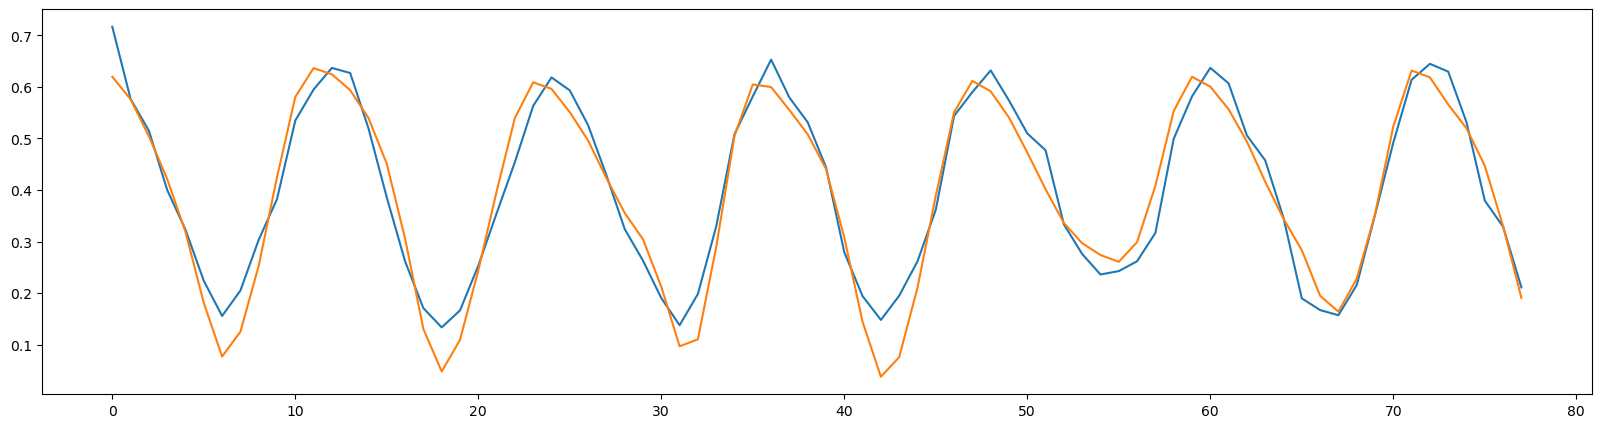

In [87]:
prediction = gm.predict(test_features)
plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(prediction)), prediction)
plt.plot(np.arange(len(prediction)), y[150:])
plt.show()

In [33]:
print(gm.shift)
print(gm.scale)

[ 0.91232746  0.91515561 -0.94846906 -0.03189558 -0.02597572  0.13501549]
[ 0.0039309  -0.00032568  0.00189799  0.05788542  0.00562682 -0.00639207]


(6, 78)


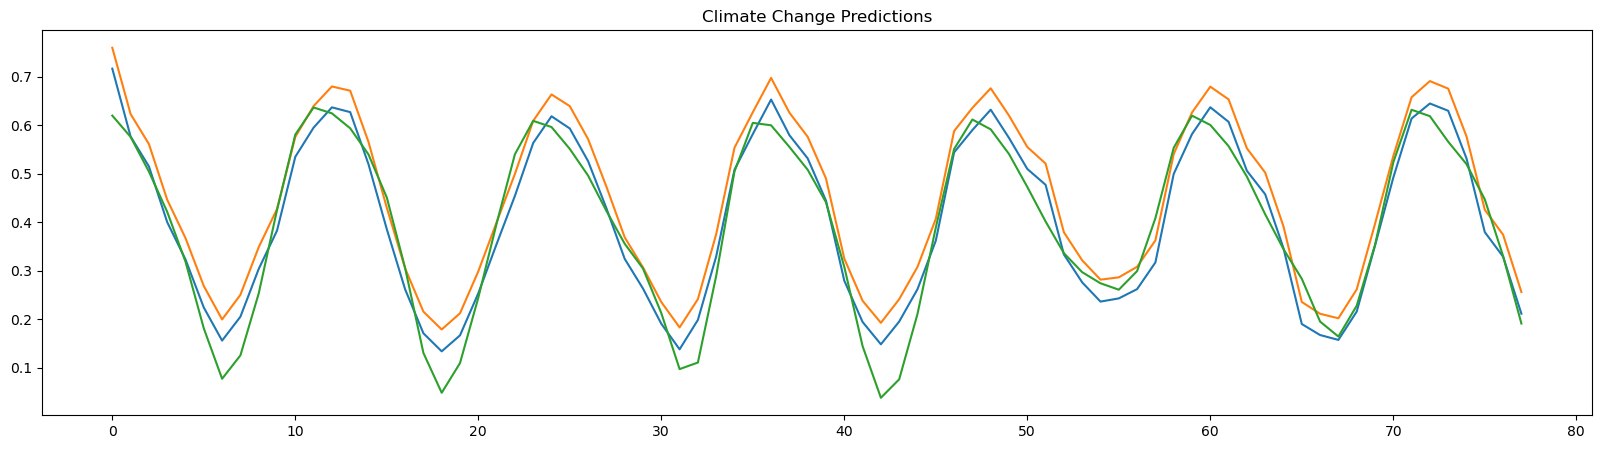

In [34]:
# 9.68 to 11.53
# 49.424 52.754

# Precip decrease by 50%
climate_change_features = test_features.copy()
climate_change_features[0, :] += 3.33
climate_change_features[1, :] += 3.33
climate_change_features[2, :] += 3.33
climate_change_features[3, :] *= 0.5
climate_change_features[4, :] += 5

climate_change_preds = gm.predict(climate_change_features)

plt.figure(figsize=(20, 5))
plt.title("Climate Change Predictions")
plt.plot(np.arange(len(climate_change_preds)), prediction)
plt.plot(np.arange(len(climate_change_preds)), climate_change_preds)
plt.plot(np.arange(len(climate_change_preds)), y[150:])
plt.show()

In [13]:
def ukraine_climate_change(seasonal):
    linspace = np.linspace()
    pass